**Nama** : Alexander Agung Raya <br>
**Kelas** : TI-3H <br>
**Nim** : 2341720040

Tugas kali ini adalah mengerjakan studi kasus analisis data dan clustering menggunakan unsupervised learning dengan langkah-langkah sebagai berikut:

1. Preprocessing data
   - Tangani missing values (imputasi mean/median/modus sesuai jenis data)
   - Normalisasi atau standarisasi data
   - Buat minimal satu fitur baru hasil kombinasi fitur lama

2. Clustering
   - Terapkan K-Means dan DBSCAN
   - Bandingkan hasil clustering menggunakan:
	 - Silhouette Score
	 - Davies–Bouldin Index

3. Approximate Nearest Neighbor (ANN)
   - Gunakan Annoy untuk mencari tetangga terdekat dari beberapa query points hasil clustering
   - Tampilkan output berupa:
	 - Index query point
	 - Daftar tetangga terdekat yang ditemukan
	 - Nilai jarak / kemiripan


Tugas 1 — House Prices Dataset
Untuk mahasiswa dengan nomor absen 1, 4, 7, dst.
  - Dataset: House Prices - Advanced Regression Techniques
  - Deskripsi: Dataset ini berisi atribut rumah (luas, tipe bangunan, kondisi, lokasi, dsb.) yang dapat digunakan untuk eksplorasi fitur, penanganan missing values, dan clustering rumah dengan karakteristik mirip.
-	Langkah tambahan:
 - Fokus pada subset fitur numerik terlebih dahulu.
 - Coba buat fitur baru seperti “TotalArea = GrLivArea + TotalBsmtSF”.


1. Import library

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

Penjelasan singkat library
- pandas, numpy: manipulasi data dan operasi numerik dasar.
- StandardScaler: standarisasi fitur sebelum clustering (K-Means/DBSCAN sensitif terhadap skala).
- KMeans, DBSCAN: algoritma clustering yang dipakai (KMeans dengan n_clusters=3; DBSCAN eps=2.5, min_samples=5 — parameter sebaiknya di-tuning).
- PCA: reduksi dimensi ke 2 komponen hanya untuk visualisasi.
- silhouette_score: nilai semakin dekat ke 1 → cluster lebih baik; hitung hanya untuk sampel non-noise pada DBSCAN.
- davies_bouldin_score: nilai lebih kecil → cluster lebih baik.
- AnnoyIndex (Annoy): ANN cepat untuk pencarian tetangga; menggunakan metrik euclidean dan 10 trees di build(); output menampilkan index query, daftar tetangga, jarak, dan label KMeans dari tetangga.
- Praktik preprocessing yang diterapkan:
    - Imputasi missing numeric dengan mean.
    - Membuat fitur baru: TotalArea = GrLivArea + TotalBsmtSF.
    - Standarisasi seluruh fitur numerik (scaler disimpan agar dapat digunakan kembali).
- Catatan evaluasi & debugging:
    - Untuk DBSCAN, abaikan label -1 saat menghitung silhouette/davies-bouldin.
    - Bereksperimen dengan jumlah trees di Annoy dan jumlah neighbor yang diminta untuk trade-off akurasi vs kecepatan.
    - Visualisasikan hasil (PCA 2D) untuk inspeksi manual dan validasi intuisi cluster.

Load Dataset

In [ ]:
df = pd.read_csv(r'D:\File untuk kuliah\Semester-5\Pembelajaran Mesin\Praktek\MachineLearning_Smst5_2025\UTS\Assets\train.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Memuat dataset `House Prices - Advanced Regression Techniques` (file `train.csv` dari Kaggle (https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=train.csv)).

Langkah inspeksi awal:
- `df.info()` untuk melihat jumlah baris, tipe data tiap kolom, dan kolom yang memiliki missing values.
- `df.head()` untuk melihat contoh baris dan struktur data.


Preprocessing Data

In [7]:
num_df = df.select_dtypes(include=['float64', 'int64']).copy()
num_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


- `num_df = df.select_dtypes(include=['float64', 'int64']).copy()`
    - `num_df = df.select_dtypes(include=['float64', 'int64']).copy()`
    - Memilih semua kolom numerik bertipe float64 atau int64 dari DataFrame `df`.
    - Membuat salinan (`.copy()`) sehingga perubahan pada `num_df` tidak mempengaruhi `df` (menghindari warning/efek samping).

- `num_df.head()`
    - `num_df.head()`
    - Menampilkan 5 baris pertama dari `num_df` untuk inspeksi cepat.

Tujuan keseluruhan: mengambil subset fitur numerik untuk preprocessing/analisis (mis. imputasi, normalisasi, pembuatan fitur baru) dan melihat struktur datanya.

missing values

In [8]:
print(num_df.isnull().sum()[num_df.isnull().sum() > 0])
num_df.fillna(num_df.mean(), inplace=True)

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


- `print(num_df.isnull().sum()[num_df.isnull().sum() > 0])`
    - Menghitung jumlah nilai kosong (NaN) tiap kolom di `num_df`, memfilter hanya kolom yang memiliki >0 NaN, lalu menampilkannya. Berguna untuk mengetahui kolom mana yang perlu di-imputasi.

- `num_df.fillna(num_df.mean(), inplace=True)`
    - Mengisi (imputasi) nilai NaN pada setiap kolom numerik dengan mean (rata‑rata) kolom tersebut: `num_df.fillna(num_df.mean(), inplace=True)`.
    - `inplace=True` berarti perubahan diterapkan langsung ke `num_df`.
    - Catatan: jika sebuah kolom seluruhnya NaN, mean akan NaN dan kolom tetap berisi NaN; untuk fitur non‑numerik diperlukan strategi imputasi berbeda (modus, konstanta, dsb.).

- Kesimpulan Hasil :
    - LotFrontage    259  
        - Ada 259 nilai kosong pada kolom LotFrontage (~259/1460 = 17.74%). proporsi cukup besar — pertimbangkan imputasi lebih hati‑hati (median, group‑median per Neighborhood, atau model imputer) atau tanda khusus jika missing bermakna.

    - MasVnrArea       8  
        - Hanya 8 nilai kosong (~0.55%). kecil, imputasi mean/median biasanya aman. Periksa juga MasVnrType: jika tipe = None, area = 0 bisa lebih masuk akal daripada mean.

    - GarageYrBlt     81  
        - 81 nilai kosong (~5.55%). seringkali NaN pada GarageYrBlt berarti rumah tidak punya garasi; menggantinya dengan mean tahun bisa menyesatkan. Lebih baik:
            - buat fitur biner GarageExists (1 jika ada garasi, 0 jika tidak), lalu imputasi GarageYrBlt hanya untuk yang punya garasi (atau isi dengan 0/median dan gunakan GarageExists sebagai konteks).

    Note : hasil ini dibuat code `print(num_df.isnull().sum()[num_df.isnull().sum() > 0])`. Setelah itu Anda menjalankan `num_df.fillna(num_df.mean(), inplace=True)` sehingga nilai‑nilai NaN pada kolom numerik akan digantikan oleh rata‑rata kolom (kecuali kolom yang seluruhnya NaN). Pastikan strategi imputasi sesuai konteks tiap kolom, bukan selalu mean.

Membuat fitur baru

In [ ]:
num_df['TotalArea'] = num_df['GrLivArea'] + num_df['TotalBsmtSF']

membuat fitur gabungan `TotalArea` (luas lantai + basement) yang bisa menambah informasi untuk clustering.

Normalisasi / Standarisasi

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

`StandardScaler` mengubah tiap fitur menjadi distribusi dengan mean=0 dan std=1.
Mengapa penting? K-Means dan DBSCAN berbasis jarak : fitur dengan skala besar akan mendominasi jika tidak distandarisasi.

`X_scaled` menjadi `numpy.ndarray` 2D siap untuk clustering.

Clustering

In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

sil_kmeans = silhouette_score(X_scaled, labels_kmeans)
dbi_kmeans = davies_bouldin_score(X_scaled, labels_kmeans)
print(f"KMeans - Silhouette: {sil_kmeans:.4f}, Davies–Bouldin: {dbi_kmeans:.4f}")


c:\Users\ASUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ASUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\ASUS\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ASUS\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^

KMeans - Silhouette: 0.1302, Davies–Bouldin: 2.7149


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


`KMeans(n_clusters=3)` membuat 3 cluster.
`fit_predict` menyesuaikan model dan memberi label cluster tiap sampel.

Metrik evaluasi:
 - Silhouette Score ∈ [-1, 1], lebih tinggi → cluster lebih baik (separation & cohesion).
 - Davies–Bouldin Index (DBI), lebih rendah → cluster lebih baik (antara-cluster similarity rendah).

Note: pemilihan `n_clusters` sebaiknya divalidasi (elbow method, silhouette range, atau mencoba beberapa nilai).

DBSCAN

In [13]:
dbscan = DBSCAN(eps=2.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

mask = labels_dbscan != -1
if len(np.unique(labels_dbscan[mask])) > 1:
    sil_dbscan = silhouette_score(X_scaled[mask], labels_dbscan[mask])
    dbi_dbscan = davies_bouldin_score(X_scaled[mask], labels_dbscan[mask])
else:
    sil_dbscan, dbi_dbscan = np.nan, np.nan

print(f"DBSCAN - Silhouette: {sil_dbscan:.4f}, Davies–Bouldin: {dbi_dbscan:.4f}")


DBSCAN - Silhouette: 0.2462, Davies–Bouldin: 1.3664


`DBSCAN` adalah clustering density-based; eps = radius tetangga, min_samples = min poin di sekitar untuk jadi core point.

`labels_dbscan` memberi -1 untuk noise/outlier.

Mask: kamu mengecualikan noise saat menghitung metrik itu langkah tepat karena metrik seperti silhouette memerlukan label-cluster valid (>1 cluster).


Visualisasi Clustering

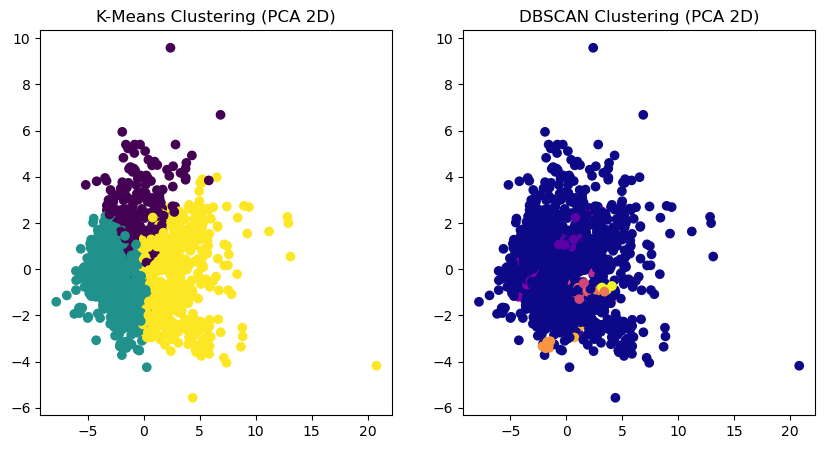

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='viridis')
plt.title("K-Means Clustering (PCA 2D)")

plt.subplot(1,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='plasma')
plt.title("DBSCAN Clustering (PCA 2D)")

plt.show()


- PCA mereduksi dimensi ke 2 supaya bisa divisualisasikan.
- Warna berdasarkan label cluster.

Approximate Nearest Neighbor (Annoy)

In [ ]:
dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Masukkan data
for i, vec in enumerate(X_scaled):
    ann.add_item(i, vec.tolist())

ann.build(10) 


True

`AnnoyIndex`(dim, 'euclidean') membuat indeks ANN untuk dimensi dim dengan metrik Euclidean.

`add_item`(i, vec) menambahkan tiap vektor ke indeks dengan id i

`build(10)` membangun 10 pohon : akurasi pencarian lebih baik tapi ukuran + waktu build lebih besar.

In [18]:
query_points = np.random.choice(len(X_scaled), 3, replace=False)

for q in query_points:
    neighbors, distances = ann.get_nns_by_item(q, 5, include_distances=True)
    print(f"\n Query Point Index: {q}")
    for n, d in zip(neighbors, distances):
        print(f"Neighbor Index: {n} | Distance: {d:.4f} | Cluster (KMeans): {labels_kmeans[n]}")



 Query Point Index: 1172
Neighbor Index: 1172 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 687 | Distance: 2.5348 | Cluster (KMeans): 1
Neighbor Index: 285 | Distance: 2.5384 | Cluster (KMeans): 1
Neighbor Index: 1236 | Distance: 2.5549 | Cluster (KMeans): 2
Neighbor Index: 578 | Distance: 2.6677 | Cluster (KMeans): 1

 Query Point Index: 387
Neighbor Index: 387 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 674 | Distance: 3.0263 | Cluster (KMeans): 1
Neighbor Index: 509 | Distance: 3.4766 | Cluster (KMeans): 1
Neighbor Index: 254 | Distance: 3.7269 | Cluster (KMeans): 1
Neighbor Index: 269 | Distance: 3.7708 | Cluster (KMeans): 1

 Query Point Index: 1022
Neighbor Index: 1022 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 514 | Distance: 3.0552 | Cluster (KMeans): 1
Neighbor Index: 1345 | Distance: 3.0895 | Cluster (KMeans): 1
Neighbor Index: 1119 | Distance: 3.2475 | Cluster (KMeans): 1
Neighbor Index: 121 | Distance: 3.5343 | Cluster (KMeans): 1


`np.random.choice(..., 3, replace=False)` memilih 3 indeks acak sebagai query points.

`get_nns_by_item(q, 5, include_distances=True)` mencari 5 tetangga terdekat untuk item q. Catatan: Annoy biasanya mengembalikan item itu sendiri sebagai neighbor pertama (distance 0).


Kesimpulan

In [19]:
import pandas as pd

# Buat tabel hasil evaluasi
hasil = pd.DataFrame({
    'Model': ['KMeans', 'DBSCAN'],
    'Silhouette Score': [sil_kmeans, sil_dbscan],
    'Davies–Bouldin Index': [dbi_kmeans, dbi_dbscan]
})

print("\n=== Hasil Evaluasi Clustering ===")
print(hasil)



=== Hasil Evaluasi Clustering ===
    Model  Silhouette Score  Davies–Bouldin Index
0  KMeans          0.130191              2.714852
1  DBSCAN          0.246227              1.366378


- Hasil dari Evaluasi Clustering (Silhouette Score (Semakin Tinggi => Semakin Baik))
  - KMeans: 0.13 : Clutternya agak lemah
  - DBSCAN: 0.24 : Hasilnya bagus tapi masih lemah

- Hasil dari Evaluasi Clustering Davies–Bouldin Index (Semakin Rendah => Semakin Baik)
  - KMeans: 2.71 : buruk
  - DBSCAN: 1.36 : Hasil Baik